# 房价预测

这是大作业的代码文件，只涉及到代码和简单的备注说明，详细的解释请参考报告。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from collections import Counter
warnings.filterwarnings('ignore')

## 第一部分
对数据进行预处理

In [3]:
# 数据预处理

train_df = pd.read_csv('train.csv')
#打印出数据，观察数据异常值情况
print('原始数据：\n',train_df)
train_df = train_df.drop('Id',axis=1)

# 1. 只挑出是数字的项
# train_num = train_df.select_dtypes(include = ['float64', 'int64'])
# print(train_num.shape)

# 2. 把字符类型的变换成数字
for column in train_df:
    if train_df[column].dtype =='object':
        train_df[column] = pd.factorize(train_df[column])[0]+1
train_num = train_df.copy()

print(train_num.isnull().sum())
#将可能的0值替换成空值
train_num = train_num.replace(0, np.NAN)
#替换空值为平均值
train_num = train_num.fillna(train_num.mean(skipna=True))
print('最终训练集数据：\n',train_num)


原始数据：
         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea Poo

In [4]:
# 测试集做同样的操作
test_df = pd.read_csv('test.csv')
test_df = test_df.drop('Id',axis=1)

# 1. 只挑出是数字的项
# train_num = train_df.select_dtypes(include = ['float64', 'int64'])
# print(train_num.shape)

# 2. 把字符类型的变换成数字
for column in test_df:
    if test_df[column].dtype =='object':
        test_df[column] = pd.factorize(test_df[column])[0]+1
test_num = test_df.copy()

#将可能的0值替换成空值
test_num = test_num.replace(0, np.NAN)
#替换空值为平均值
test_num = test_num.fillna(test_num.mean(skipna=True))
print('最终测试集数据：\n',test_num.shape)

最终测试集数据：
 (1459, 79)


由于特征过多，训练时可能会耗费大量的时间，所以还要做降维处理。这里采用PCA。

In [5]:
# 对数据进行降维
# 去除标签值
X = np.array(train_num.drop('SalePrice',axis=1))
print(X.shape)
X = X.T

# 对样本进行中心化
for i in range(len(X)):
    tmp = np.mean(X[i])
    avg = np.full((1, len(X[i])), tmp)
    X[i] = X[i] - tmp

# 求协方差矩阵
cov = np.dot(X, X.T)
# print('协方差矩阵为：\n',cov)

# 做特征值分解
vals,vecs = np.linalg.eig(cov)
# print("该矩阵的特征值:",vals)
# print("该矩阵的特征向量:",vecs)

# 选取降维后的维数k
idx = np.argsort(-vals)
sortvals = vals[idx]

vsum = np.sum(vals)
tsum = 0
for i in range(len(sortvals)):
    tsum += sortvals[i]
    if tsum/vsum > 0.99:        # 改成>0.999结果就有6维
        k = i+1
        break
print('降维后的维数为：\n',k)

# 构建投影矩阵
c = [(vals[i], vecs[i]) for i in range(len(vals))]
sorted(c)
# print('排序后特征向量为：\n',c)

W = np.array([c[i][1] for i in range(k)])
# print('投影矩阵：\n',W)

# 得到降维后数据集
tmpY = np.dot(W, X)
X_redu = tmpY.T
print('降维后的训练集形状：\n', X_redu.shape)

(1460, 79)
降维后的维数为：
 2
降维后的训练集形状：
 (1460, 2)


## 2. 模型训练

2.1 用线性回归模型预测

In [24]:
# 评估预测结果，使用MSE均方误差
def MSE(y, y_hat):
    # y是真实值，y_hat是预测值
    m=len(y)
    return np.sum((y-y_hat)**2)/m

In [8]:
# 线性回归   
eta=0.001             # 学习率
epoch=10000           # 迭代次数
w = [1.0, 1.0, 1.0]   # 初始化参数

x2 = X_redu.copy()    # 特征值

# min-max 标准化
y2 = np.array(train_num['SalePrice']).reshape(-1,1)       # 标签
Y_mean = min(y2[:,0])
Y_std = max(y2[:,0]) - min(y2[:,0])
y2 = (y2 - Y_mean) / Y_std      # 归一化

# z-score 标准化
X_mean = np.mean(x2, axis=0)       # 均差
X_std = np.std(x2, axis=0)         # 标准差
x2 = (x2 - X_mean) / X_std         # 归一化

# 批量梯度下降    均方误差MSE =  6031669411.467354
for i in range(epoch):
    temp = 0
    temp_w=[0.0, 0.0, 0.0]
    for j in range(X_redu.shape[0]):
        temp = w[0] + w[1]*x2[j][0] + w[2]*x2[j][1] - y2[j][0]
        temp_w[0] += temp / len(x2)
        temp_w[1] += x2[j][0] * temp / len(x2)
        temp_w[2] += x2[j][1] * temp / len(x2)
    for k in range(len(w)):
        w[k] -= eta * temp_w[k]

# 还原w
# print("w:",w)
w[0] = w[0] * Y_std + Y_mean
for i in range(1,len(w)):
    w[i] = w[i] * X_std[i-1] + X_mean[i-1]
print("最终w值:",w)

# 得到降维后测试数据集Y
tmp_test = np.dot(W,np.array(test_num).T)
test_redu = tmp_test.T
print('降维后的测试数据集：\n',test_redu.shape)
test_redu = np.c_[np.ones(len(test_redu)),test_redu]                     

最终w值: [180947.12895084725, 1.251742393791111, -14.473699808536509]
降维后的测试数据集：
 (1459, 2)


In [26]:
# 以下为对于测试集的测试
def linear_pre(test_redu, w):
    ans = np.dot(test_redu,w).reshape(-1,1)     # 预测结果
    print("线性回归预测结果：\n",ans)

    sample_submission = pd.read_csv('sample_submission.csv')                       # 读取提交样例
    sample_ans = np.array(sample_submission['SalePrice']).reshape(-1,1)            # 读取提交样例中的标签
    part = np.sum((ans-sample_ans)**2)        # 部分和
    MSE = part / len(sample_submission)
    print("线性回归均方误差MSE = ", MSE)

    norm_ans = 2*(ans-min(ans[:,0])) / (max(ans[:,0])-min(ans[:,0])) -1
    sample_norm_ans = 2*(sample_ans-min(sample_ans[:,0])) / (max(sample_ans[:,0])-min(sample_ans[:,0])) -1
    print('线性回归的归一化均方误差为：', np.sum((norm_ans-sample_norm_ans)**2 / len(sample_submission)))
    return ans

# linear_pre(test_redu, w)

2.2 用神经网络模型预测

In [10]:
# 神经网络

#降维后的数据预处理
#训练集
train_x=X_redu
train_y=np.array(train_num['SalePrice']).reshape(-1,1)
min_train_y=np.min(train_y)
Regular_train_y=np.max(train_y)-np.min(train_y)
#标签归一化[-1,1]
train_y=2*(train_y-min_train_y)/Regular_train_y-1
# print(train_y)
train_data=np.concatenate((train_x,train_y),axis=1)
# print(train_data.shape)

#测试集
test_x = np.dot(W,np.array(test_num).T).T
test_y = np.array(pd.read_csv("sample_submission.csv").drop("Id",axis=1)).reshape(-1,1)
min_test_y = np.min(test_y)
Regular_test_y = np.max(test_y)-np.min(test_y)

#标签归一化[-1,1]
test_y = 2*(test_y-min_test_y)/Regular_test_y-1     # 归一化后的结果
# print(test_y)
test_data = np.concatenate((test_x,test_y),axis=1)
# print(test_data.shape)

#读入tensor格式的训练集和测试集
train=torch.from_numpy(train_data)
test=torch.from_numpy(test_data)

In [11]:
# 定义神经网络模型，继承自nn.Module
class Net(nn.Module):
    #输入层的维度为 input_dim
    #隐藏层的维度为 hidden_dim
    #输出层的维度为 output_dim
    def __init__(self, input_dim, dim1, dim2, dim3, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, dim1)
        self.fc2 = nn.Linear(dim1, dim2)
        self.fc3 = nn.Linear(dim2, dim3)
        self.fc4 = nn.Linear(dim3, output_dim)
        #激活函数relu，用于在全连接层之间加入非线性变换
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, x):
        out0 = self.fc1(x)
        out1 = self.relu(out0)
        out2 = self.fc2(out1)
        out3 = self.relu(out2)
        out4 = self.fc3(out3)
        out5 = self.tanh(out4)
        out = self.fc4(out5)
        return out5,out
# 创建神经网络模型实例
net = Net(2,8,12,10,1)
# print(net)

In [12]:
# 分离特征和标签
# 训练数据
inputs_train=train[:,:-1].float()
labels_train=train[:,-1].float().reshape(-1,1)
# 测试数据
inputs_test=test[:,:-1].float()
labels_test=test[:,-1].float().reshape(-1,1)
# 选择优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
# 记录每一轮的训练损失和测试损失
losses_train=[]
losses_test=[]
Epoch=200
for epoch in range(Epoch):
    _,output2_train=net(inputs_train)                       # 前向传播
    _,output2_test=net(inputs_test)
    loss_train = criterion(output2_train, labels_train)     # 计算损失
    loss_test = criterion(output2_test, labels_test)
    optimizer.zero_grad()                                   # 梯度清零
    loss_train.backward()                                   # 反向传播(用训练集的损失反向传播！)
    optimizer.step()                                        # 更新参数
    losses_train.append(loss_train.item())                  # 记录损失
    losses_test.append(loss_test.item())
    # print('Epoch [{}/{}], Loss: {}'.format(epoch+1,Epoch, loss_train))


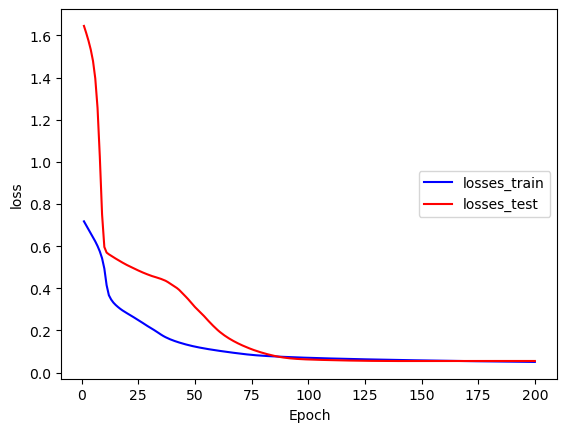

In [13]:
#训练损失和测试损失关于迭代轮次的折线图
x=[i for i in range(1,Epoch+1)]
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(x,losses_train,c='b')
plt.plot(x,losses_test,c='r')
plt.legend(["losses_train","losses_test"],loc='right')

In [31]:
# 输入测试集，获取预测结果predict
def network_pre(inputs_test): 
    _, predict = net(inputs_test)
    # 转为numpy格式
    predict=predict.detach().numpy()
    for i in predict:
        i=i.item()
        # print(i,end='')
        # print((i+1)*Regular_test_y/2+min_test_y)
    # 预测房价（解归一化）
    y_hat = (predict+1)*Regular_test_y/2+min_test_y
    print('\n神经网络的预测结果：\n',y_hat)
    # 真实房价（重新读取）
    y=np.array(pd.read_csv("sample_submission.csv").drop("Id",axis=1)).reshape(-1,1)
    # 计算均方误差
    print("神经网络的均方误差：",MSE(y, y_hat))
    # 归一化后的均方误差
    print("归一化后的均方误差:",MSE(test_y,predict))
    return y_hat

# network_pre(inputs_test)

## 2.3 随机森林

In [15]:
# 随机森林
# 类节点
class Node:
    def __init__(self, feature_index=None, threshold=None, value=None, left=None, right=None):
        self.feature_index = feature_index  # 特征索引
        self.threshold = threshold          # 分裂阈值
        self.value = value                  # 叶子节点的预测值
        self.left = left                    # 左子树
        self.right = right                  # 右子树

In [16]:
class RegTree:
    def __init__(self, max_depth=6):
        self.max_depth = max_depth          # 最大深度
        self.tree = None                    # 决策树
    # 计算当前子集y标签的方差
    def _calculate_variance(self, y):
        return np.var(y)
    # 按照划分阈值划分，得到掩码以及其互补掩码
    def _split_data(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]
    
    #选出最佳划分特征和划分阈值
    def _find_best_split(self, X, y):
        #只剩一行就不分
        m, n = X.shape
        if m <= 1:
            return None, None
        #当前标签的方差
        current_variance = self._calculate_variance(y)
        #初始化划分参数
        best_variance_reduction = 0
        best_feature_index = None
        best_threshold = None
        #遍历当前剩余特征
        for feature_index in range(n):
            thresholds = np.unique(X[:, feature_index])
            #遍历当前剩余特征的特征值，枚举划分阈值
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
                #边缘值不算
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                #左右划分权重
                left_weight = len(y_left) / m
                right_weight = len(y_right) / m
                #当前划分能减少的差值
                variance_reduction = current_variance - (left_weight * self._calculate_variance(y_left)
                                                         + right_weight * self._calculate_variance(y_right))
                #比较
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def _build_tree(self, X, y, depth):
        if depth == 0 or np.unique(y).shape[0] == 1:
            return Node(value=np.mean(y))
        #当前子集的最佳划分及其阈值
        feature_index, threshold = self._find_best_split(X, y)
        #没划分就取均值作为最终的预测值
        if feature_index is None:
            return Node(value=np.mean(y))
        #按照划分，得到左右子集
        X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
        #建左右子树，深度-1
        left_subtree = self._build_tree(X_left, y_left, depth - 1)
        right_subtree = self._build_tree(X_right, y_right, depth - 1)
        
        return Node(feature_index=feature_index, threshold=threshold, left=left_subtree, right=right_subtree)

    def train(self, X, y):
        self.tree = self._build_tree(X, y, depth=self.max_depth)

    def _predict_sample(self, node, sample):
        #节点值不为空，即为叶节点，即预测值
        if node.value is not None:
            return node.value
        elif sample[node.feature_index] <= node.threshold:
            return self._predict_sample(node.left, sample)
        else:
            return self._predict_sample(node.right, sample)

    def predict(self, X):
        return np.array([self._predict_sample(self.tree, sample) for sample in X])

In [17]:
#开始训练(整个训练集一起)
D = np.array(train_num)
reg_tree = RegTree()
X = D[:, :-1]
y = D[:, -1]
reg_tree.train(X, y)

# 进行预测
test_data = np.array(test_num)
predictions = reg_tree.predict(test_data)
predictions = predictions.reshape(-1, 1)
print("预测：\n",predictions)


预测：
 [[124109.98319328]
 [140236.48648649]
 [177793.80203046]
 ...
 [164039.46296296]
 [124109.98319328]
 [245489.67567568]]


In [18]:
# bootstrap采样
n = 20
m = train_num.shape[0]

def bootstrap(m):
    train_index = np.random.choice(m, replace=True, size=m)
    train_data = D[train_index,]  
    return train_data

In [19]:
#对每个采样的数据集训练出来树
trees = []
for i in range(n):
    rt = RegTree()
    train_data = bootstrap(m)
    X = train_data[:, :-1]  
    y = train_data[:, -1]
    rt.train(X, y)
    trees.append(rt)

In [30]:
#简单平均法
def randforest_pre(test_data):
    result = np.zeros((test_data.shape[0], 1))
    for i in range(n):
        temp1=trees[i].predict(test_data)
        result += trees[i].predict(test_data).reshape(-1, 1)
    result /= n
    result = result.reshape(-1, 1)
    print("\n随机森林结果：\n", result)

    MSE_df = pd.read_csv('sample_submission.csv')
    actual_y = np.array(MSE_df)[:, -1].reshape(-1, 1)
    print("随机森林的MSE:", MSE(actual_y, result))

    norm_res = 2*(result-min(result)) / (max(result)-min(result)) -1
    print('随机森林的归一化MSE：',MSE(test_y, norm_res))
    return result

# randforest_pre(test_data)

In [21]:
#MSE，评估模型
# MSE_df = pd.read_csv('sample_submission.csv')
# actual_y = np.array(MSE_df)[:, -1].reshape(-1, 1)
# print("真实值：\n", actual_y)

# print("单棵回归树的MSE：\n", MSE(actual_y, predictions))
# print("随机森林的MSE：\n", MSE(actual_y, result))

## 3. 对三种模型进行集成

In [32]:
# 用简单平均法进行集成
res1 = linear_pre(test_redu,w)
res2 = network_pre(inputs_test)
res3 = randforest_pre(test_data)

result = np.mean(np.concatenate((res1,res2,res3),axis=1),axis=1)
result = result.reshape(-1,1)
print('\n最终结果为:\n',result)

# 用均方误差评估模型
MSE_df = pd.read_csv('sample_submission.csv')
actual_y = np.array(MSE_df)[:, -1].reshape(-1, 1)
print('均方误差为：',MSE(actual_y, result))

# 预测结果归一化
norm_result = 2*(result-np.min(result)) / (np.max(result)-np.min(result)) -1
print('归一化后的均方误差为：', MSE(test_y, norm_result))

线性回归预测结果：
 [[190191.99361021]
 [195343.96227816]
 [191356.5985216 ]
 ...
 [194267.00084505]
 [190842.53127044]
 [191957.61470052]]
线性回归均方误差MSE =  426696851.97584474
线性回归的归一化均方误差为： 0.1371993116990624

神经网络的预测结果：
 [[177946.16]
 [177954.45]
 [177954.45]
 ...
 [177954.45]
 [177925.72]
 [177946.83]]
神经网络的均方误差： 293651992.2264387
归一化后的均方误差: 0.05518561960848269

随机森林结果：
 [[125142.72453705]
 [148960.40037096]
 [170096.23826032]
 ...
 [149526.85784111]
 [124843.87677684]
 [223474.90986671]]
随机森林的MSE: 4447653456.194012
随机森林的归一化MSE： 0.10854921585446238

最终结果为：
 [[164426.95813242]
 [174086.27192471]
 [179802.42996897]
 ...
 [173916.10393705]
 [164537.3755991 ]
 [197793.11756408]]
均方误差为： 638239846.0942875
归一化后的均方误差为： 0.09193931236192225
